In [7]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from beschess.components.utils import lr_range_test
from beschess.components.net.resnet import SEResEmbeddingNet, ResEmbeddingNet
from beschess.components.loss import ProxyAnchor
from beschess.data.embedding import (
    BalancedBatchSampler,
    PuzzleDataset,
    generate_split_indices,
)

In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
DATA_DIR = "../data/processed/"
quiet_boards_file = DATA_DIR + "quiet_boards_preeval.npy"
puzzle_boards_file = DATA_DIR + "boards_packed.npy"
puzzle_labels_file = DATA_DIR + "tags_packed.npy"

quiet_boards = np.load(quiet_boards_file, mmap_mode="r")
puzzle_boards = np.load(puzzle_boards_file, mmap_mode="r")
puzzle_labels = np.load(puzzle_labels_file, mmap_mode="r")

dataset = PuzzleDataset(
    quiet_boards=quiet_boards,
    puzzle_boards=puzzle_boards,
    puzzle_labels=puzzle_labels,
)

splits = generate_split_indices(dataset)
q_train, p_train = splits["train"]

train_dl = DataLoader(
    dataset,
    batch_sampler=BalancedBatchSampler(
        dataset, 
        q_train, 
        p_train,
        batch_size=128,
    ),
    num_workers=4,
)

<class 'numpy.ndarray'>


Building label map: 100%|██████████| 2042635/2042635 [00:09<00:00, 207536.41it/s]


In [4]:
model = SEResEmbeddingNet(
    embedding_dim=128,
    num_blocks=10,
    reduction=16,
).to(device)

loss = ProxyAnchor(
    n_classes=16,
    embedding_dim=128,
    margin=0.1,
    alpha=32,
).to(device)

optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "weight_decay": 1e-4},
        {"params": loss.parameters(), "weight_decay": 0},
    ]
)

In [5]:
lrs, losses = lr_range_test(
    model=model,
    loss_fn=loss,
    optimizer=optimizer,
    dataloader=train_dl,
    start_lr=1e-6,
    end_lr=1,
    num_iters=1000,
    device=device,
)

LR Range Test: 100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


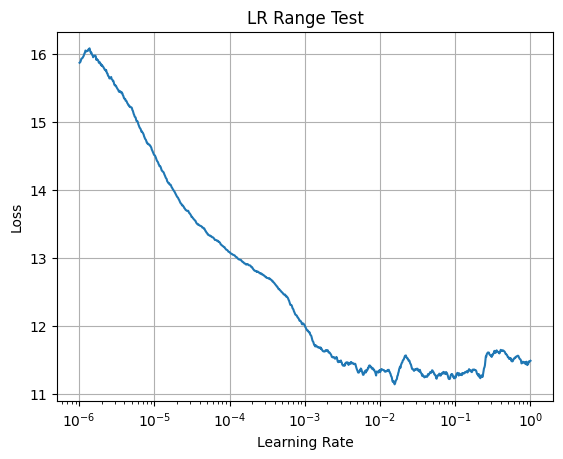

In [6]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.grid(True)
plt.show()